## 8 Bits load flow

Before use, install the bitsandbytes package by

<code> pip install -i https://pypi.org/simple/ bitsandbytes </code>


In [ ]:
from sfm.data.sci_data.SFMDecTokenizer import SFMDecTokenizer
import torch
import os
from transformers import AutoTokenizer, AutoModelForCausalLM,BitsAndBytesConfig, AutoModel,AutoConfig

In [ ]:
tokenizer_home = '/home/v-nanlinguo/hai1/ds_dataset/llama2/llama-2-7b'
tokenizer = SFMDecTokenizer.from_pretrained(
    tokenizer_home,
    prot_spm_path='/home/v-nanlinguo/hai1/shufxi/scigpt/ur50bpe/bpe',
    dna_spm_path='/home/v-nanlinguo/hai1/shufxi/scigpt/dnabpe/bpe',
    rna_spm_path='/home/v-nanlinguo/hai1/shufxi/scigpt/rnabpe/bpe',
)

In [ ]:
ckpt_home = "/home/v-nanlinguo/hai1/nanlin/scigpt/20240521022823+mulopt100K/global_step334" # checkpoint path
tmp_save_path = "./model" # save the parameters loaded on cpu temporarily to use load_in_8bits in from_pretrained, load_in_8bits is not supported when loading ckpt using from_pretrained
def show_ckpt(name, ckpt):
    for k, v in ckpt.items():
        if 'dummy' not in k:
            print(name, k, v.shape)

model = AutoModelForCausalLM.from_pretrained(tokenizer_home)

model_dict = model.state_dict()
ckpt_dict = {}
layer0 = torch.load(os.path.join(ckpt_home, "layer_00-model_states.pt"), map_location=torch.device("cpu"))
ckpt_dict['model.embed_tokens.weight'] = layer0['embed_tokens.weight']
show_ckpt('layer0', layer0)

for l in range(0, 32):
    l_index = str(l + 1).zfill(2)
    layer = torch.load(os.path.join(ckpt_home, f"layer_{l_index}-model_states.pt"), map_location=torch.device("cpu"))
    show_ckpt(l_index, layer)
    for k in layer:
        if "dummy" in k or 'rotary_emb' in k:
            continue
        ckpt_dict[f"model.layers.{l}.{k}"] = layer[k]
layer = torch.load(os.path.join(ckpt_home, "layer_33-model_states.pt"), map_location=torch.device("cpu"))
show_ckpt(33, layer)
ckpt_dict["model.norm.weight"] = layer["norm.weight"]

layer = torch.load(os.path.join(ckpt_home, "layer_34-model_states.pt"), map_location=torch.device("cpu"))
show_ckpt(33, layer)
ckpt_dict["lm_head.weight"] = layer["lm_head.weight"]
model_dict.update(ckpt_dict)

model.resize_token_embeddings(len(tokenizer))
model.load_state_dict(model_dict)
model.save_pretrained(tmp_save_path) # save the parameters loaded on cpu temporarily to use load_in_8bits in from_pretrained, load_in_8bits is not supported when loading ckpt using from_pretrained
del model

model = AutoModelForCausalLM.from_pretrained(tmp_save_path, quantization_config=BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=6.0))

In [8]:
print(f"current model size is {round(model.get_memory_footprint()/1024/1024/1024,2)}GB")

current model size is 6.67GB


### Test result

The preformance test results of molecular optimization are quite close

#### 1、Improved ratio

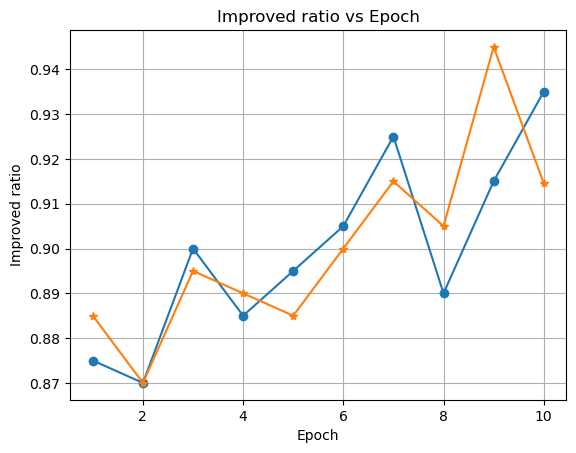

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

test_result_ori = pd.read_csv("logger/test_mul_opt_ori.csv")
test_result_8b = pd.read_csv("logger/test_mul_opt_8b.csv")

epochs = list(range(1, 11)) 
test_results_ori = test_result_ori.iloc[:10,1] 
test_results_8b = test_result_8b.iloc[:10,1] 
plt.plot(epochs, test_results_ori, marker='o',label="Ori")
plt.plot(epochs, test_results_8b, marker='*',label="8b")
plt.title('Improved ratio vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Improved ratio')
plt.grid(True)
plt.show()

#### 2、Improved logS

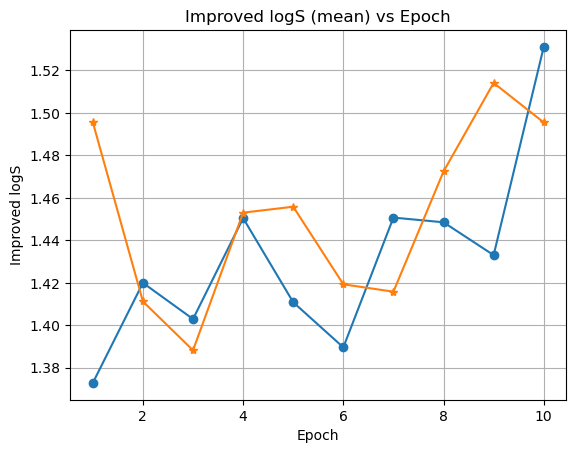

In [23]:
test_results_ori = test_result_ori.iloc[:10,2] 
test_results_8b = test_result_8b.iloc[:10,2] 
plt.plot(epochs, test_results_ori, marker='o',label="Ori")
plt.plot(epochs, test_results_8b, marker='*',label="8b")
plt.title('Improved logS (mean) vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Improved logS')
plt.grid(True)
plt.show()

### Inference speed
The quantized version is slower than the original version (4.6s vs 0.9s / prompt)
#### 1、Quantized

In [11]:
from time import perf_counter
prompt = "Improve the redox potential and solubility of molecule <mol>C[C@H](Br)C(=O)N(C)[C@@H](C)C#N</mol> : <mol>"
input_ids = tokenizer(prompt, return_tensors='pt').input_ids.cuda()

start = perf_counter()
output = model.generate(
        input_ids,
        num_beams=4,
        max_new_tokens=100,
        num_return_sequences=1,
        return_dict_in_generate=True,
        output_scores=True,
        do_sample=False,
    )
end = perf_counter()

print(f"inference speed {end-start}s/prompt")

#post processing
output_ids = output.sequences[0]
s = tokenizer.decode(output_ids)    
first_end_idx = s.find('</mol>') + len('</mol>')
s = s[first_end_idx:]
start_idx = s.find('<mol>') + len('<mol>')
end_idx = s.find('</mol>')
s = s[start_idx:end_idx]
mol = s.replace(' <m>', '').replace(' <a>', '')
print(f"output mol {mol}")

inference speed 4.597242320887744s/prompt
output mol CC(C)(C)C(=O)N1CCCO1 


#### 2、Original version

In [9]:
model_ori = AutoModelForCausalLM.from_pretrained(tmp_save_path)
model_ori.cuda()

start = perf_counter()
output = model_ori.generate(
        input_ids,
        num_beams=4,
        max_new_tokens=100,
        num_return_sequences=1,
        return_dict_in_generate=True,
        output_scores=True,
        do_sample=False
    )
end = perf_counter()

print(f"inference speed {end-start}s/prompt")

#post processing
output_ids = output.sequences[0]
s = tokenizer.decode(output_ids)    
first_end_idx = s.find('</mol>') + len('</mol>')
s = s[first_end_idx:]
start_idx = s.find('<mol>') + len('<mol>')
end_idx = s.find('</mol>')
s = s[start_idx:end_idx]
mol = s.replace(' <m>', '').replace(' <a>', '')
print(f"output mol {mol}")



Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


inference speed 0.9481499437242746s/prompt
output mol CC(C)(C)C(=O)N1CCCO1 
